In [1]:
import time

In [2]:
tic = time.time()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Loading dataframes

In [4]:
data_path = os.path.abspath('/content/drive/MyDrive/test_assignment_cv_engineer_data/')

In [5]:
df_georges = pd.read_csv(os.path.join(data_path, 'georges.csv'), header=None, names=['link'])
df_non_georges = pd.read_csv(os.path.join(data_path, 'non_georges.csv'), header=None, names=['link'])

In [6]:
df_georges.head(5)

link
0  https://i.pinimg.com/736x/17/0d/5b/170d5b93d80...
1  https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...
2  https://i.pinimg.com/736x/90/e8/90/90e890f054b...
3  https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...
4  https://i.pinimg.com/736x/f1/95/be/f195bea0b78...

In [7]:
df_non_georges.head(5)

link
0  https://i.pinimg.com/736x/fd/65/bb/fd65bb679b7...
1  https://i.pinimg.com/736x/78/63/a2/7863a2404af...
2  https://i.pinimg.com/736x/bc/3a/f4/bc3af41444c...
3  https://i.pinimg.com/736x/46/a3/59/46a3595eec7...
4  https://i.pinimg.com/736x/54/b2/ef/54b2ef7af71...

In [8]:
print(f'Classes distribution: georges = {df_georges.shape[0]}, non georges = {df_non_georges.shape[0]}')

Classes distribution: georges = 2681, non georges = 3366


Let's look at some images

In [9]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=0d0a0e8b9166b65c398641b44a218249eb56eaef0a10e1ce8a753a7448380679
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [10]:
import wget
temp_url = df_georges.iloc[0, 0]
georges_example_path = '/content/george.jpg'
wget.download(temp_url, georges_example_path)

'/content/george.jpg'

In [11]:
temp_url = df_non_georges.iloc[0, 0]
non_georges_example_path = '/content/non_george.jpg'
wget.download(temp_url, non_georges_example_path)

'/content/non_george.jpg'

In [ ]:
georges_example = plt.imread(georges_example_path)

plt.figure(figsize=(10, 15))
plt.imshow(georges_example)

In [ ]:
non_georges_example = plt.imread(non_georges_example_path)

plt.figure(figsize=(10, 15))
plt.imshow(non_georges_example)

Getting all images

In [14]:
general_df = pd.DataFrame(columns=['image_name', 'class_name', 'class_id'])

In [15]:
class2idx = {'george': 0, 'non_george': 1}

In [16]:
images_folder = os.path.join('/content/drive/MyDrive/test_assignment', 'images')

In [18]:
os.makedirs(images_folder, exist_ok=True)

In [19]:
from tqdm import tqdm

def get_images(df: pd.DataFrame, dest_folder_path: os.path, class_name: str) -> None:
    for item in tqdm(df.itertuples()):
        image_name = os.path.split(item.link)[1]
        wget.download(item.link, os.path.join(dest_folder_path, image_name))
        general_df.loc[len(general_df)] = [image_name, class_name, class2idx[class_name]]

In [20]:
print('Getting George images:')
get_images(df=df_georges, dest_folder_path=images_folder, class_name='george')
print('Getting Non George images:')
get_images(df=df_non_georges, dest_folder_path=images_folder, class_name='non_george')

0it [00:00, ?it/s]

Getting George images:


2681it [11:56,  3.74it/s]
1it [00:00,  5.40it/s]

Getting Non George images:


3366it [11:18,  4.96it/s]


In [21]:
general_df.head(5)

image_name class_name class_id
0  170d5b93d80d247be60f22ca1216bef7.jpg     george        0
1  47b99a2ddcde2cf9e62b4faeec2fdf20.jpg     george        0
2  90e890f054b920308987c140125c9d19.jpg     george        0
3  0a716f6f14eea3adc30e0944a7123759.jpg     george        0
4  f195bea0b78d1c0c90ab54341bf39536.jpg     george        0

In [22]:
general_df_path = os.path.join('/content/drive/MyDrive/test_assignment/', 'df.csv')
general_df.to_csv(general_df_path, index=False)

Images have been loaded, now creating datasets

In [23]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch

In [24]:
from PIL import Image
class GeorgeDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame,
        image_folder: os.path,
        transform: transforms or None):

        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.image_folder,
                                self.df.loc[idx, 'image_name'])
        image = Image.open(img_path, 'r')
        if image.mode!='RGB':
            # some images are in gray scale format
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': self.df.loc[idx, 'class_id']}

        return sample

In [109]:
# we are gonna use some classic transforms for training
train_transforms = transforms.Compose([
        transforms.RandomChoice(
            [
                transforms.RandomResizedCrop(size=(224, 224)), 
                transforms.Resize((224, 224)),
            ]
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(general_df.index.values,
                                                      general_df.class_id.values,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=True)

In [28]:
general_df['split'] = 'train'
general_df.loc[X_valid, 'split'] = 'valid'

Train/val class distributions

In [29]:
general_df[general_df['split']=='train'].groupby('class_id').size()

class_id
0    2124
1    2713
dtype: int64

In [30]:
general_df[general_df['split']=='valid'].groupby('class_id').size()

class_id
0    557
1    653
dtype: int64

Let's create a config class

In [134]:
class Config:
    train_batch_size = 32
    valid_batch_size = 10
    n_epochs = 30
    lr = 0.005
    seed = 42
    folder = '/content/drive/MyDrive/test_assignment/runs'
    images_folder = '/content/drive/MyDrive/test_assignment/images'
    df_path = '/content/drive/MyDrive/test_assignment/df.csv'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    OptimizerClass = torch.optim.AdamW
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
         mode='max',
         factor=0.5,
         patience=2,
         verbose=True, 
         threshold=0.0001,
         threshold_mode='abs',
         cooldown=0, 
         min_lr=1e-8,
         eps=1e-08
     )

In [111]:
train_dataset = GeorgeDataset(df=general_df[general_df['split']=='train'],
                              image_folder=Config.images_folder,
                              transform=train_transforms)

valid_dataset = GeorgeDataset(df=general_df[general_df['split']=='valid'],
                              image_folder=Config.images_folder,
                              transform=valid_transforms)

In [118]:
train_loader = DataLoader(train_dataset,
                          batch_size=Config.train_batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)

valid_loader = DataLoader(valid_dataset,
                          batch_size=Config.valid_batch_size,
                          shuffle=False,
                          num_workers=4)

In [113]:
from torchvision import models

In [119]:
# let's take middle class model, not great, not terrible
model = models.resnet50(pretrained=True)

In [120]:
# changing head to our num of classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

In [122]:
# we have not that big dataset,
# so it has to be nice, to train just the head of the model
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

Working with a model

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [125]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [135]:
from torch.nn import CrossEntropyLoss
from tqdm.notebook import tqdm, trange
from datetime import datetime
import copy
from sklearn.metrics import accuracy_score

# I would like to use the fitter class which I usually use in my research

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_acc = -1
        self.model = model
        self.device = device

        self.criterion = CrossEntropyLoss()
        param_optimizer = list(self.model.named_parameters())

        self.optimizer = config.OptimizerClass(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        history_dict = {}

        history_dict['epoch'] = []
        history_dict['train_loss'] = []
        history_dict['val_loss'] = []
        history_dict['train_lr'] = []
        history_dict['val_accuracy'] = []

        tr = trange(self.config.n_epochs)
        for e in tr:
            history_dict['epoch'].append(self.epoch)
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            
            if self.config.verbose:
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            train_loss, loss_trend, lr_trend = self.train_epoch(train_loader)
            
            history_dict['train_loss'].append(loss_trend)
            history_dict['train_lr'].append(lr_trend)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {train_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            val_loss, loss_trend, val_acc, acc_trend = self.validation(validation_loader)
            history_dict['val_loss'].append(loss_trend)
            history_dict['val_accuracy'].append(acc_trend)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {val_loss.avg:.5f}, summary_acc: {val_acc.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if val_acc.avg > self.best_summary_acc:
                self.best_summary_acc = val_acc.avg
                self.model.eval()
                checkpoint_name = f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch_acc={val_acc.avg:.3f}.bin'
                self.save(checkpoint_name)
                
                try:
                    os.remove(f)
                except:pass
                f = copy.deepcopy(checkpoint_name)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=val_acc.avg)

            self.epoch += 1

        
        plt.figure(figsize=(15, 10))
        plt.plot([np.mean(i) for i in history_dict['train_loss']], label = 'train_loss')
        plt.plot([np.mean(i) for i in history_dict['val_loss']], label = 'val_loss')
        plt.plot([np.mean(i) for i in history_dict['val_accuracy']], label = 'val_accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss/Accuracy')
        plt.legend()
        plt.savefig(os.path.split(self.log_path)[0]+f'/metrics.jpg')

        return history_dict

    def train_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
        lr_trend = []
        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )            
            images = batch['image']
            labels = batch['label']

            images = images.to(self.device).float()
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output.float(), labels)
            loss.backward()
            summary_loss.update(loss.detach().item(), self.config.train_batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

            
            lr = self.optimizer.param_groups[0]['lr']
            loss_trend.append(summary_loss.avg)
            lr_trend.append(lr)
        return summary_loss, loss_trend, lr_trend
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        summary_acc = AverageMeter()

        t = time.time()
        loss_trend = []
        acc_trend = []
        for step, batch in tqdm(enumerate(val_loader), total=len(val_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():

                images = batch['image']
                labels = batch['label']

                images = images.to(self.device).float()
                labels = labels.to(self.device)

                output = self.model(images)

                
                loss = self.criterion(output.float(), labels)
                summary_loss.update(loss.detach().item(), self.config.valid_batch_size)

                current_acc = accuracy_score(labels.cpu().numpy(), output.argmax(axis=1).cpu().numpy())
                summary_acc.update(current_acc, self.config.valid_batch_size)

                loss_trend.append(summary_loss.avg)
                acc_trend.append(summary_acc.avg)
        return summary_loss, loss_trend, summary_acc, acc_trend
    
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_accuracy': self.best_summary_acc,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_acc = checkpoint['best_summary_accuracy']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

Fitter prepared. Device is cuda:0



2021-02-22T19:45:12.093740
LR: 0.005


Train Step 150/151, summary_loss: 0.58967, time: 30.32274
[RESULT]: Train. Epoch: 0, summary_loss: 0.58863, time: 30.42867


Val Step 120/121, summary_loss: 0.40174, time: 7.94131
[RESULT]: Val. Epoch: 0, summary_loss: 0.40550, summary_acc: 0.84380, time: 8.01390

2021-02-22T19:45:51.223497
LR: 0.005



[RESULT]: Train. Epoch: 1, summary_loss: 0.55203, time: 30.66477



[RESULT]: Val. Epoch: 1, summary_loss: 0.48244, summary_acc: 0.81570, time: 8.01468

2021-02-22T19:46:30.260736
LR: 0.005



[RESULT]: Train. Epoch: 2, summary_loss: 0.47160, time: 30.27675



[RESULT]: Val. Epoch: 2, summary_loss: 0.48447, summary_acc: 0.82562, time: 8.02240

2021-02-22T19:47:08.910373
LR: 0.005



[RESULT]: Train. Epoch: 3, summary_loss: 0.47870, time: 30.37343



[RESULT]: Val. Epoch: 3, summary_loss: 0.45985, summary_acc: 0.83140, time: 7.94626
Epoch     4: reducing learning rate of group 0 to 2.5000e-03.

2021-02-22T19:47:47.598195
LR: 0.0025


Train Step 150/151, summary_loss: 0.41183, time: 30.45253
[RESULT]: Train. Epoch: 4, summary_loss: 0.41177, time: 30.55305



[RESULT]: Val. Epoch: 4, summary_loss: 0.40889, summary_acc: 0.84298, time: 7.94639

2021-02-22T19:48:26.454027
LR: 0.0025



[RESULT]: Train. Epoch: 5, summary_loss: 0.41498, time: 30.45255


Val Step 120/121, summary_loss: 0.48598, time: 7.88139
[RESULT]: Val. Epoch: 5, summary_loss: 0.48525, summary_acc: 0.81322, time: 7.94720

2021-02-22T19:49:05.214402
LR: 0.0025



[RESULT]: Train. Epoch: 6, summary_loss: 0.47347, time: 30.54344



[RESULT]: Val. Epoch: 6, summary_loss: 0.67137, summary_acc: 0.75868, time: 8.01901
Epoch     7: reducing learning rate of group 0 to 1.2500e-03.

2021-02-22T19:49:44.117867
LR: 0.00125



[RESULT]: Train. Epoch: 7, summary_loss: 0.38519, time: 30.51208


Val Step 120/121, summary_loss: 0.38411, time: 7.90756
[RESULT]: Val. Epoch: 7, summary_loss: 0.38612, summary_acc: 0.84876, time: 7.96973

2021-02-22T19:50:23.302041
LR: 0.00125



[RESULT]: Train. Epoch: 8, summary_loss: 0.39685, time: 30.50581



[RESULT]: Val. Epoch: 8, summary_loss: 0.38193, summary_acc: 0.83636, time: 7.95237

2021-02-22T19:51:02.140038
LR: 0.00125


Train Step 150/151, summary_loss: 0.37962, time: 30.36997
[RESULT]: Train. Epoch: 9, summary_loss: 0.38100, time: 30.47186


Val Step 120/121, summary_loss: 0.40448, time: 7.94813
[RESULT]: Val. Epoch: 9, summary_loss: 0.40545, summary_acc: 0.83719, time: 8.01481

2021-02-22T19:51:41.005886
LR: 0.00125


Train Step 150/151, summary_loss: 0.39917, time: 30.33711
[RESULT]: Train. Epoch: 10, summary_loss: 0.39978, time: 30.43699



[RESULT]: Val. Epoch: 10, summary_loss: 0.38335, summary_acc: 0.83388, time: 7.98742
Epoch    11: reducing learning rate of group 0 to 6.2500e-04.

2021-02-22T19:52:19.776185
LR: 0.000625



[RESULT]: Train. Epoch: 11, summary_loss: 0.36278, time: 30.66951



[RESULT]: Val. Epoch: 11, summary_loss: 0.37414, summary_acc: 0.84876, time: 8.00286

2021-02-22T19:52:58.802094
LR: 0.000625



[RESULT]: Train. Epoch: 12, summary_loss: 0.37849, time: 30.36532


Val Step 120/121, summary_loss: 0.36406, time: 7.91001
[RESULT]: Val. Epoch: 12, summary_loss: 0.36696, summary_acc: 0.84628, time: 7.97763

2021-02-22T19:53:37.509751
LR: 0.000625



[RESULT]: Train. Epoch: 13, summary_loss: 0.36340, time: 30.67571


Val Step 120/121, summary_loss: 0.37501, time: 7.94391
[RESULT]: Val. Epoch: 13, summary_loss: 0.37753, summary_acc: 0.85041, time: 8.01173

2021-02-22T19:54:16.891693
LR: 0.000625



[RESULT]: Train. Epoch: 14, summary_loss: 0.36779, time: 30.84060


Val Step 120/121, summary_loss: 0.37505, time: 7.97289
[RESULT]: Val. Epoch: 14, summary_loss: 0.37935, summary_acc: 0.83719, time: 8.03763

2021-02-22T19:54:56.155867
LR: 0.000625



[RESULT]: Train. Epoch: 15, summary_loss: 0.36692, time: 30.60422



[RESULT]: Val. Epoch: 15, summary_loss: 0.36551, summary_acc: 0.84959, time: 8.17146

2021-02-22T19:55:35.295815
LR: 0.000625



[RESULT]: Train. Epoch: 16, summary_loss: 0.37307, time: 30.45673


Val Step 120/121, summary_loss: 0.37964, time: 7.92626
[RESULT]: Val. Epoch: 16, summary_loss: 0.38120, summary_acc: 0.84380, time: 7.99553
Epoch    17: reducing learning rate of group 0 to 3.1250e-04.

2021-02-22T19:56:14.095186
LR: 0.0003125


Train Step 150/151, summary_loss: 0.35977, time: 30.49876
[RESULT]: Train. Epoch: 17, summary_loss: 0.35924, time: 30.59958



[RESULT]: Val. Epoch: 17, summary_loss: 0.36654, summary_acc: 0.84545, time: 8.01498

2021-02-22T19:56:53.073376
LR: 0.0003125


Train Step 150/151, summary_loss: 0.36345, time: 30.28131
[RESULT]: Train. Epoch: 18, summary_loss: 0.36339, time: 30.39369


Val Step 120/121, summary_loss: 0.36797, time: 7.98193
[RESULT]: Val. Epoch: 18, summary_loss: 0.37123, summary_acc: 0.83884, time: 8.04707

2021-02-22T19:57:31.860568
LR: 0.0003125



[RESULT]: Train. Epoch: 19, summary_loss: 0.37053, time: 30.53780


Val Step 120/121, summary_loss: 0.36188, time: 7.98586
[RESULT]: Val. Epoch: 19, summary_loss: 0.36480, summary_acc: 0.85041, time: 8.06047
Epoch    20: reducing learning rate of group 0 to 1.5625e-04.

2021-02-22T19:58:10.808854
LR: 0.00015625



[RESULT]: Train. Epoch: 20, summary_loss: 0.34677, time: 30.50278


Val Step 120/121, summary_loss: 0.36469, time: 7.90714
[RESULT]: Val. Epoch: 20, summary_loss: 0.36699, summary_acc: 0.85124, time: 7.96873

2021-02-22T19:58:49.999613
LR: 0.00015625


Train Step 150/151, summary_loss: 0.36812, time: 30.64952
[RESULT]: Train. Epoch: 21, summary_loss: 0.36893, time: 30.75548


Val Step 120/121, summary_loss: 0.36895, time: 7.91751
[RESULT]: Val. Epoch: 21, summary_loss: 0.37319, summary_acc: 0.83719, time: 7.98146

2021-02-22T19:59:29.093840
LR: 0.00015625


Train Step 150/151, summary_loss: 0.35729, time: 30.55042
[RESULT]: Train. Epoch: 22, summary_loss: 0.35657, time: 30.65438


Val Step 120/121, summary_loss: 0.35352, time: 7.85476
[RESULT]: Val. Epoch: 22, summary_loss: 0.35637, summary_acc: 0.85785, time: 7.92270

2021-02-22T20:00:08.374587
LR: 0.00015625


Train Step 150/151, summary_loss: 0.35405, time: 30.48727
[RESULT]: Train. Epoch: 23, summary_loss: 0.35410, time: 30.58866


Val Step 120/121, summary_loss: 0.36423, time: 7.95653
[RESULT]: Val. Epoch: 23, summary_loss: 0.36654, summary_acc: 0.85289, time: 8.01886

2021-02-22T20:00:47.382111
LR: 0.00015625



[RESULT]: Train. Epoch: 24, summary_loss: 0.35767, time: 30.57089



[RESULT]: Val. Epoch: 24, summary_loss: 0.35830, summary_acc: 0.85702, time: 8.03067

2021-02-22T20:01:26.367527
LR: 0.00015625



[RESULT]: Train. Epoch: 25, summary_loss: 0.35136, time: 30.53947



[RESULT]: Val. Epoch: 25, summary_loss: 0.36221, summary_acc: 0.85289, time: 8.13348
Epoch    26: reducing learning rate of group 0 to 7.8125e-05.

2021-02-22T20:02:05.412957
LR: 7.8125e-05



[RESULT]: Train. Epoch: 26, summary_loss: 0.35727, time: 30.49302


Val Step 120/121, summary_loss: 0.35944, time: 7.93755
[RESULT]: Val. Epoch: 26, summary_loss: 0.36230, summary_acc: 0.85207, time: 8.00139

2021-02-22T20:02:44.266678
LR: 7.8125e-05



[RESULT]: Train. Epoch: 27, summary_loss: 0.34260, time: 30.43407



[RESULT]: Val. Epoch: 27, summary_loss: 0.36216, summary_acc: 0.85207, time: 8.06385

2021-02-22T20:03:23.145565
LR: 7.8125e-05



[RESULT]: Train. Epoch: 28, summary_loss: 0.34753, time: 30.79529



[RESULT]: Val. Epoch: 28, summary_loss: 0.35867, summary_acc: 0.85702, time: 8.08795
Epoch    29: reducing learning rate of group 0 to 3.9063e-05.

2021-02-22T20:04:02.412530
LR: 3.90625e-05



[RESULT]: Train. Epoch: 29, summary_loss: 0.33967, time: 30.56983


Val Step 120/121, summary_loss: 0.35866, time: 8.01179
[RESULT]: Val. Epoch: 29, summary_loss: 0.36163, summary_acc: 0.85124, time: 8.07983



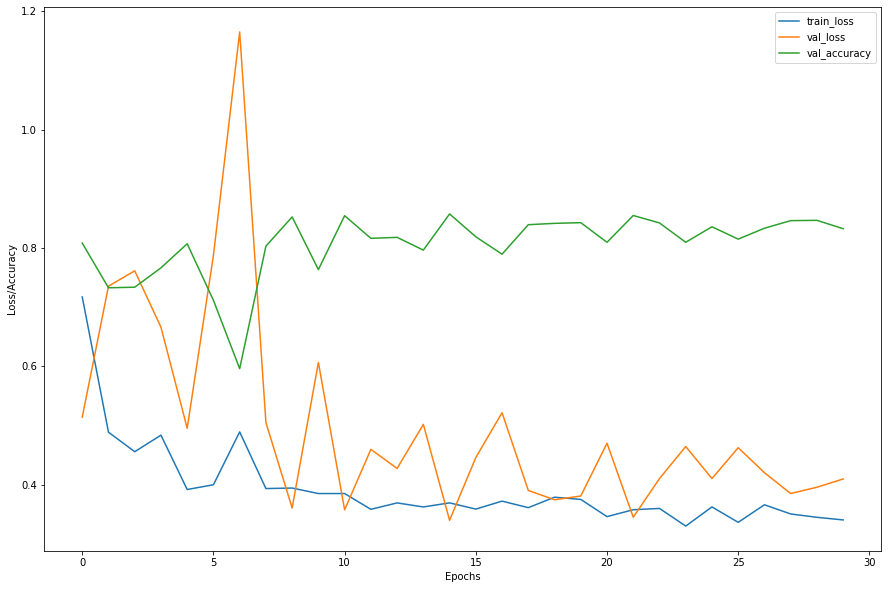

In [136]:
fitter = Fitter(model=model, device=device, config=Config)  
history_dict = fitter.fit(train_loader, valid_loader)

In [141]:
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
checkpoint_names = [i  for i in os.listdir(Config.folder) if i.startswith('best')]
checkpoint_path = os.path.join(Config.folder, checkpoint_names[0])
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [142]:
idx2class = {value: key for key, value in class2idx.items()}

In [143]:
valid_images_len = len(general_df[general_df['split']=='valid'])

In [150]:
image_id = np.random.randint(0, valid_images_len-1)
test_image_name = general_df[general_df['split']=='valid'].iloc[image_id, 0]
gt_class = general_df[general_df['split']=='valid'].iloc[image_id, 1]
print(f'Filename: {test_image_name}')
test_image_path = os.path.abspath(os.path.join(images_folder, test_image_name))
init_image = Image.open(test_image_path, 'r')
if init_image.mode!='RGB':
    init_image = init_image.convert('RGB')
image = valid_transforms(init_image)
image = image.unsqueeze(0)
model.to(device)
with torch.no_grad():
    image = image.to(device).float()
    output = model(image)
print(f'Predicted class is {idx2class[output.argmax(axis=1).item()]}')
print(f'Ground truth is {gt_class}')
# plt.imshow(init_image);

Filename: 008ee0b9f6bca98d16fe8108375e4d78.jpg
Predicted class is non_george
Ground truth is non_george


In [151]:
tac = time.time()

In [152]:
print(f"Spent time is {np.abs(tic-tac)/60/60:.2f} hours")

Spent time is 2.78 hours
